In [1]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input,Dense,GlobalAvgPool2D
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.callbacks import EarlyStopping,CSVLogger,ModelCheckpoint,ReduceLROnPlateau
from captcha.image import ImageCaptcha  
import matplotlib.pyplot as plt
import numpy as np
import random
import string
from plot_model import plot_model

/Users/qin/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# 字符包含所有数字和所有大小写英文字母，一共62个
characters = string.digits + string.ascii_letters
# 类别数
num_classes = len(characters)
# 批次大小
batch_size = 64
# 训练集批次数
# 训练集大小相当于是64*1000=64000
train_steps = 1000
# 测试集批次数
# 测试集大小相当于是64*100=6400
test_steps = 100
# 周期数
epochs=100
# 图片宽度
width=160
# 图片高度
height=60

In [3]:
# 用于自定义数据生成器
from tensorflow.keras.utils import Sequence

# 这里的Sequence定义其实不算典型，因为一般的数据集数量是有限的，
# 把所有数据训练一次属于训练一个周期，一个周期可以分为n个批次，
# Sequence一般是定义一个训练周期内每个批次的数据如何产生。
# 我们这里的验证码数据集使用captcha模块生产出来的，一边生产一边训练，可以认为数据集是无限的。
class CaptchaSequence(Sequence):
    # __getitem__和__len__是必须定义的两个方法
    def __init__(self, characters, batch_size, steps, n_len=4, width=160, height=60):
        # 字符集
        self.characters = characters
        # 批次大小
        self.batch_size = batch_size
        # 生成器生成多少个批次的数据
        self.steps = steps
        # 验证码长度
        self.n_len = n_len
        # 验证码图片宽度
        self.width = width
        # 验证码图片高度
        self.height = height
        # 字符集长度
        self.num_classes = len(characters)
        # 用于产生验证码图片
        self.image = ImageCaptcha(width=self.width, height=self.height)
        # 用于保存最近一个批次验证码字符
        self.captcha_list = []
    
    # 获得index位置的批次数据
    def __getitem__(self, index):
        # 初始化数据用于保存验证码图片
        x = np.zeros((self.batch_size, self.height, self.width, 3), dtype=np.float32)
        # 初始化数据用于保存标签
        # n_len是多任务学习的任务数量，这里是4个任务，batch批次大小，num_classes分类数量
        y = np.zeros((self.n_len, self.batch_size, self.num_classes), dtype=np.uint8)
        # 数据清0
        self.captcha_list = []
        # 生产一个批次数据
        for i in range(self.batch_size):
            # 随机产生验证码
            captcha_text = ''.join([random.choice(self.characters) for j in range(self.n_len)])
            self.captcha_list.append(captcha_text)
            # 生产验证码图片数据并进行归一化处理
            x[i] = np.array(self.image.generate_image(captcha_text)) / 255.0
            # j(0-3),i(0-61),ch(单个字符)
            # self.characters.find(ch)得到c在characters中的位置，可以理解为c的编号
            for j, ch in enumerate(captcha_text):
                # 设置标签，独热编码one-hot格式
                y[j, i, self.characters.find(ch)] = 1
        # 返回一个批次的数据和标签
        return x, [y[0],y[1],y[2],y[3]]
    
    # 返回批次数量
    def __len__(self):
        return self.steps 

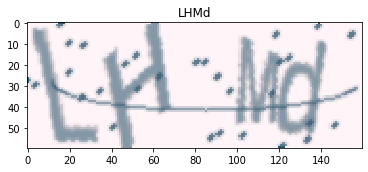

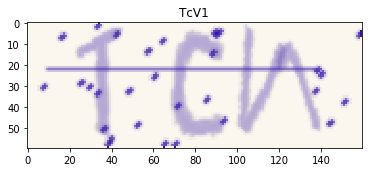

In [4]:
# 测试生成器
# 一共一个批次，批次大小也是1
data = CaptchaSequence(characters, batch_size=1, steps=1)
for i in range(2):
    # 产生一个批次的数据
    x, y = data[0]
    # 显示图片
    plt.imshow(x[0])
    # 验证码字符和对应编号
    plt.title(data.captcha_list[0])
    plt.show()

In [5]:
# 载入预训练的resnet50模型
resnet50 = ResNet50(weights='imagenet', include_top=False, input_shape=(height,width,3))

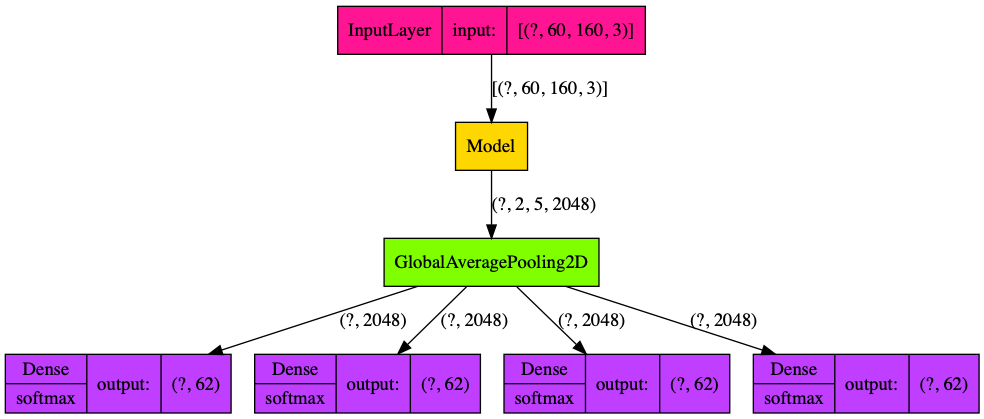

In [94]:
# 设置输入
inputs = Input((height,width,3))
# 使用resnet50进行特征提取
x = resnet50(inputs)
# 平均池化
x = GlobalAvgPool2D()(x)
# 把验证码识别的4个字符看成是4个不同的任务
# 每个任务负责识别1个字符
# 任务1识别第1个字符，任务2识别第2个字符，任务3识别第3个字符，任务4识别第4个字符
x0 = Dense(num_classes, activation='softmax', name='out0')(x)
x1 = Dense(num_classes, activation='softmax', name='out1')(x)
x2 = Dense(num_classes, activation='softmax', name='out2')(x)
x3 = Dense(num_classes, activation='softmax', name='out3')(x)
# 定义模型
model = Model(inputs, [x0,x1,x2,x3])
# 画图
plot_model(model,style=0)

In [7]:
# 4个任务我们可以定义4个loss
# loss_weights可以用来设置不同任务的权重，验证码识别的4个任务权重都一样
model.compile(loss={'out0':'categorical_crossentropy',
                    'out1':'categorical_crossentropy',
                    'out2':'categorical_crossentropy',
                    'out3':'categorical_crossentropy'},
              loss_weights={'out0':1,
                            'out1':1,
                            'out2':1,
                            'out3':1},
              optimizer=SGD(lr=1e-2,momentum=0.9),
              metrics=['acc'])

# 监控指标统一使用val_loss
# 可以使用EarlyStopping来让模型停止，连续6个周期val_loss没有下降就结束训练
# CSVLogger保存训练数据
# ModelCheckpoint保存所有训练周期中val_loss最低的模型
# ReduceLROnPlateau学习率调整策略，连续3个周期val_loss没有下降当前学习率乘以0.1
callbacks = [EarlyStopping(monitor='val_loss', patience=6, verbose=1),
             CSVLogger('Captcha.csv'), 
             ModelCheckpoint('Best_Captcha.h5', monitor='val_loss', save_best_only=True),
             ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)]

In [8]:
# 训练模型
model.fit(x=CaptchaSequence(characters, batch_size=batch_size, steps=train_steps),
          epochs=epochs,
          validation_data=CaptchaSequence(characters, batch_size=batch_size, steps=test_steps),
          callbacks=callbacks)

Train for 1000 steps, validate for 100 steps
Epoch 1/100
1000/1000 [==============================] - 164s 164ms/step - loss: 10.0266 - out0_loss: 2.3069 - out1_loss: 2.7054 - out2_loss: 2.6668 - out3_loss: 2.3474 - out0_acc: 0.3711 - out1_acc: 0.3144 - out2_acc: 0.3197 - out3_acc: 0.3896 - val_loss: 3.8732 - val_out0_loss: 1.1623 - val_out1_loss: 0.9057 - val_out2_loss: 0.9186 - val_out3_loss: 0.8866 - val_out0_acc: 0.6719 - val_out1_acc: 0.7352 - val_out2_acc: 0.7278 - val_out3_acc: 0.7531
Epoch 2/100
1000/1000 [==============================] - 160s 160ms/step - loss: 0.9184 - out0_loss: 0.2026 - out1_loss: 0.2641 - out2_loss: 0.2588 - out3_loss: 0.1929 - out0_acc: 0.9303 - out1_acc: 0.9115 - out2_acc: 0.9130 - out3_acc: 0.9337 - val_loss: 1.6491 - val_out0_loss: 0.3475 - val_out1_loss: 0.4478 - val_out2_loss: 0.4444 - val_out3_loss: 0.4094 - val_out0_acc: 0.8934 - val_out1_acc: 0.8712 - val_out2_acc: 0.8662 - val_out3_acc: 0.8884
Epoch 3/100
1000/1000 [=============================

1000/1000 [==============================] - 160s 160ms/step - loss: 0.1165 - out0_loss: 0.0280 - out1_loss: 0.0303 - out2_loss: 0.0310 - out3_loss: 0.0272 - out0_acc: 0.9890 - out1_acc: 0.9883 - out2_acc: 0.9879 - out3_acc: 0.9895 - val_loss: 0.1219 - val_out0_loss: 0.0289 - val_out1_loss: 0.0363 - val_out2_loss: 0.0285 - val_out3_loss: 0.0283 - val_out0_acc: 0.9894 - val_out1_acc: 0.9869 - val_out2_acc: 0.9884 - val_out3_acc: 0.9883
Epoch 37/100
1000/1000 [==============================] - 161s 161ms/step - loss: 0.1188 - out0_loss: 0.0276 - out1_loss: 0.0334 - out2_loss: 0.0308 - out3_loss: 0.0270 - out0_acc: 0.9892 - out1_acc: 0.9869 - out2_acc: 0.9876 - out3_acc: 0.9894 - val_loss: 0.1158 - val_out0_loss: 0.0244 - val_out1_loss: 0.0298 - val_out2_loss: 0.0329 - val_out3_loss: 0.0287 - val_out0_acc: 0.9897 - val_out1_acc: 0.9881 - val_out2_acc: 0.9862 - val_out3_acc: 0.9884
Epoch 38/100
1000/1000 [==============================] - 161s 161ms/step - loss: 0.1181 - out0_loss: 0.0268 